In [9]:
import numpy as np
import sys
import glob
import pickle
import pandas as pd
import pyccl as ccl
from mpl_toolkits import axes_grid1
import matplotlib.pyplot as plt

In [10]:
%load_ext autoreload
%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods/modules/')
import abundance as cl_count
import covariance as covar
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
n_logm_bin = 4
n_z_bin = 4
logm_corner = np.linspace(14.2, 15.6, n_logm_bin + 1)
logMass_bin = binning(logm_corner)
z_corner = np.linspace(0.2,1.2, n_z_bin + 1)
Z_bin = binning(z_corner)

# Covariance Matrix Prediction (CCL + PySSC from F.Lacasa et al.)

## Fiducial cosmology (CCL)

In [33]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

## Abundance (CCL)

In [34]:
clc = cl_count.ClusterAbundance()
#choose the halo mass function and mass definition
massdef = ccl.halos.massdef.MassDef('vir', 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncDespali16(cosmo, mass_def=massdef)
halobias = ccl.halos.hbias.HaloBiasTinker10(cosmo, mass_def= massdef, mass_def_strict=True)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25) * 4 * np.pi
clc.f_sky = clc.sky_area/(4*np.pi)
z_grid = np.linspace(0.2, 2.1, 2000)
logm_grid = np.linspace(14.2, 15.6, 2001)
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
Abundance = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')
clc.compute_halo_bias_grid_MZ(z_grid = z_corner, logm_grid = logm_corner, halobiais = halobias)
NHalo_bias = clc.Nhalo_bias_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')

## Matter amplitude fluctuation (PySSC)

In [ ]:
Covariance = covar.Covariance_matrix()
#use PySSC from Lacasa et al.
Sij = Covariance.matter_fluctuation_amplitude_fullsky(Z_bin)

## Sample covariance (CCL + pySSC)

In [ ]:
Sample_covariance = Covariance.sample_covariance_full_sky(Z_bin, logMass_bin, NHalo_bias, Sij)/clc.f_sky

In [ ]:
Covariance_prediction = Sample_covariance + np.diag(Abundance.flatten())

# Covariance Matrix Estimation (Pinnochio simulations)

In [ ]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [ ]:
dat = load('/sps/lsst/users/cpayerne/1000xsimulations/analysis/binned_catalogs/4x4_binned_catalogs.pkl')

In [ ]:
N = np.array(dat,dtype=object)

In [ ]:
count = np.array(N[3])

In [ ]:
count_mean = np.mean(count, axis=0)

In [ ]:
count_mean.shape

In [ ]:
count_ordered = count.reshape(-1,(20*30))

In [ ]:
count_ordered = np.zeros([1000, n_logm_bin*n_z_bin])
for i in range(1000):
    count_ordered[i,:]=count[i].flatten()

In [ ]:
Covariance_estimation = np.cov(count_ordered.T, bias=True)

In [ ]:
mean_estimation = np.mean(count_ordered.T, axis = 1)

In [ ]:
mean_estimation_plot = mean_estimation.reshape(20,30)

In [ ]:
c = (1000 - n_logm_bin*n_z_bin -2)/(1000-1)

In [ ]:
def corr(C1, C2):
    res=np.zeros([C1.shape[0],C1.shape[1]])
    for i in range(C1.shape[0]):
        for j in range(C1.shape[0]):
            res[i,j]=C1[i,j]/np.sqrt(C2[i,i]*C2[j,j])
    return res

In [30]:
c1=corr(Covariance_estimation-np.diag(mean_estimation.flatten())/c, 
                np.diag(mean_estimation.flatten()))
c2=corr(Covariance_prediction-np.diag(Abundance.flatten()), 
                np.diag(Abundance.flatten()))
plot=np.zeros([c1.shape[0], c1.shape[1]])
for i in range(c1.shape[0]):
    for j in range(c1.shape[1]):
        if i <= j:
            plot[i,j]=c1[i,j]
        else: plot[i,j]=c2[i,j]

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


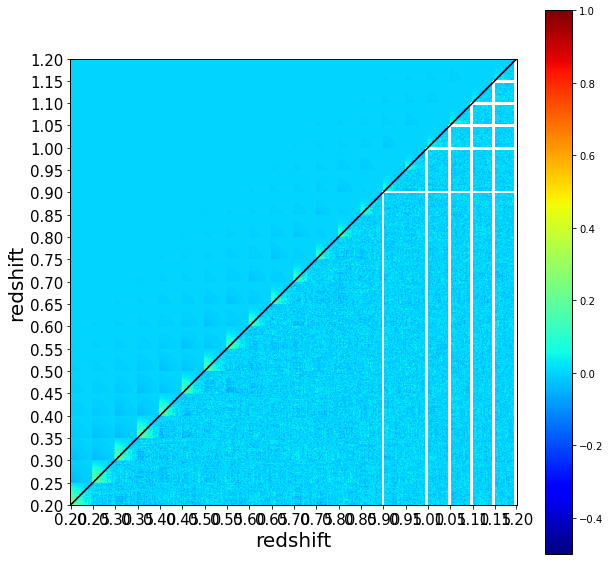

In [31]:
plt.figure(figsize=(10,10))
plt.rcParams['axes.linewidth']= 1
plt.tick_params(axis='both', which = 'major', labelsize= 15)
im=plt.imshow(plot, 
           vmin=-.5, vmax=1., 
           cmap='jet', origin='lower')
x = np.arange(len(plot[:,1]))
plt.plot(x,x,'k')
z_ticks = [f'{z:.2f}' for z in z_corner]
index = np.arange((len(Z_bin))*(len(logMass_bin)))
index_split = np.split(index, len(Z_bin))
ticks = [index_split[i][0] for i in range(len(Z_bin))]
ticks.append(len(Z_bin)*len(logMass_bin) - 1)
plt.xticks(ticks=ticks, labels=z_ticks)
plt.yticks(ticks=ticks, labels=z_ticks)
plt.xlabel('redshift', fontsize = 20)
plt.ylabel('redshift', fontsize = 20)
plt.grid(True, which='minor')
plt.grid(True, which='minor')
plt.colorbar()
#plt.savefig('R.pdf', bbox_inches='tight', dpi=300)

NameError: name 'matrix' is not defined

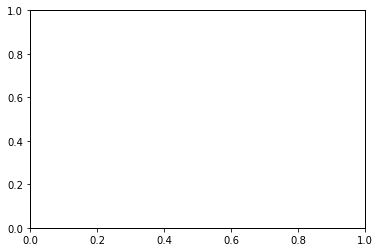

In [497]:
fig, ax = plt.subplots()
ax.imshow(matrix)
ax.set_aspect(1)
ax.set_yticks([10.5, 20.5, 30.5], minor='True')
ax.set_xticks([10.5, 20.5, 30.5], minor='True')
ax.yaxis.grid(True, which='minor')
ax.xaxis.grid(True, which='minor')

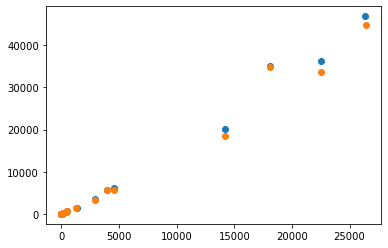

In [489]:
plt.scatter(mean_estimation.flatten(),
            Covariance_estimation.diagonal())
plt.scatter(Abundance.flatten(),
            Covariance_prediction.diagonal())